In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

import ptitprince as pt

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.utilities as utilities
import visual_behavior.ophys.response_analysis.cell_metrics as cm
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [5]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
all_expts = cache.get_ophys_experiment_table()
# print(cache_dir)

In [6]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


In [7]:
cells_table = loading.get_cell_table()

### get useful info

In [8]:
experience_levels = np.sort(experiments_table.experience_level.unique())
print(experience_levels)

['Familiar' 'Novel 1' 'Novel >1']


In [9]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [10]:
cell_types = np.sort(experiments_table.cell_type.unique())[::-1]
print(cell_types)

['Vip Inhibitory' 'Sst Inhibitory' 'Excitatory']


In [11]:
areas = np.sort(experiments_table.targeted_structure.unique())[::-1]
print(areas)

['VISp' 'VISl']


In [12]:
depths = np.sort(experiments_table.binned_depth.unique())
print(depths)

[ 75 175 275 375]


In [13]:
layers = np.sort(experiments_table.layer.unique())[::-1]
print(layers)

['upper' 'lower']


### set events & filtering

In [14]:
interpolate = True
output_sampling_rate = 30

In [15]:
ophys_experiment_ids = experiments_table.index.values

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'
data_type = 'events'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'full_dataset'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# metrics_table = get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, 
#                                                 inclusion_criteria=inclusion_criteria)
    
metrics_table = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

  0%|                                                                                          | 0/402 [00:00<?, ?it/s]

there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [08:14<00:00,  1.23s/it]
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['condition', 'data_type', 'exception', 'filter_events', 'interpolate', 'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events']]




there are 402 experiments in the returned cell_metrics table


In [16]:
if 'level_0' in metrics_table.columns: 
    metrics_table = metrics_table.drop(columns=['level_0', 'index'])
    
original_metrics_table = metrics_table.copy()

In [17]:
metrics_table = original_metrics_table.copy()

In [18]:
len(metrics_table.ophys_experiment_id.unique())

402

### Distribution of imaged depths

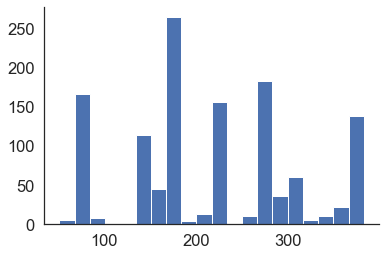

In [19]:
plt.hist(experiments_table.imaging_depth.values, bins=20);

### cell size by depth

In [20]:
lims_cells = loading.get_cell_table_from_lims(ophys_experiment_ids=experiments_table.index.values)

In [21]:
lims_cells.keys()

Index(['cell_roi_id', 'cell_specimen_id', 'ophys_experiment_id', 'x', 'y',
       'width', 'height', 'valid_roi', 'mask_matrix', 'max_correction_up',
       'max_correction_down', 'max_correction_right', 'max_correction_left',
       'mask_image_plane', 'ophys_cell_segmentation_run_id'],
      dtype='object')

In [22]:
len(lims_cells)

152328

In [23]:
lims_cells = lims_cells.merge(experiments_table, on='ophys_experiment_id')
len(lims_cells)

152328

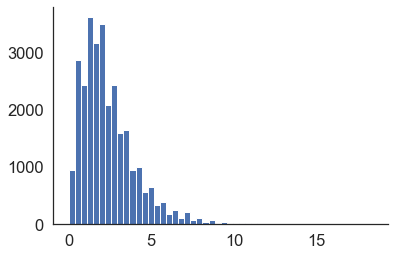

In [24]:
# how much does cell size vary from session to session? 
plt.hist(lims_cells.groupby('cell_specimen_id').std()['width'].values, bins=50);

In [25]:
# get average value for each cell_specimen_id across experiments
cells = lims_cells.groupby('cell_specimen_id').mean()[['ophys_experiment_id', 'width', 'height']]
cells = cells.merge(experiments_table, on='ophys_experiment_id')

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:1089: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



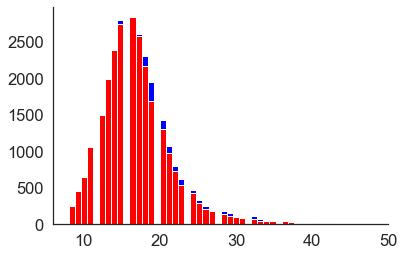

In [26]:
# are widths and heights much different? 
plt.hist(cells['width'].values, bins=50, color='blue');
plt.hist(cells['height'].values, bins=50, color='red');

### plot cell width by depth

Text(0, 0.5, 'imaging depth (um)')

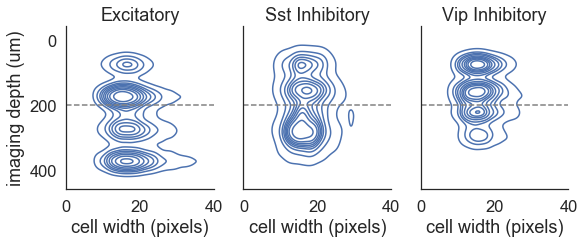

In [27]:
fig, ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
for i, cell_type in enumerate(np.sort(cells.cell_type.unique())):
    ax[i] = sns.kdeplot(data=cells[cells.cell_type==cell_type], x='width', y='imaging_depth', ax=ax[i])
    ax[i].set_title(cell_type)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('cell width (pixels)')
    ax[i].axhline(y=200, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_xlim(0, 40)
ax[0].set_ylabel('imaging depth (um)')

In [28]:
experiments_table.keys()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type', 'depth', 'binned_depth',
       'area_depth', 'area_binned_depth', 'layer', 'date', 'first_novel',
       'n_relative_to_first_novel', 'last_familiar', 'last_familiar_active',
       'second_novel', 'second_novel_active', 'experience_exposure'],
      dtype='object')

### how many cells per grouping if we split into superficial & deep

Split at 200um

In [29]:
len(experiments_table[(experiments_table.imaging_depth<200)])

610

In [30]:
len(experiments_table[(experiments_table.imaging_depth>200)])

639

Split at 250um

In [31]:
len(experiments_table[(experiments_table.imaging_depth<250)])

781

In [32]:
len(experiments_table[(experiments_table.imaging_depth>250)])

468

### distribution of change modulation index

402


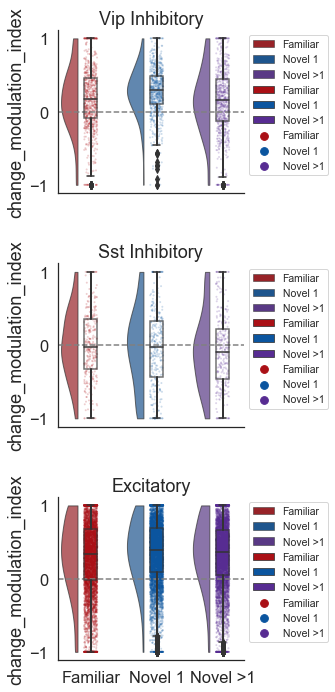

In [33]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ax[i] = pt.RainCloud(data=data[data.cell_type==cell_type], hue='experience_level',
                                x='experience_level', y=metric, palette=colors,
                                 orient='v', dodge=False, rain_alpha=0.2, point_size=2, rain_jitter=0.1,
                                 bw=0.4, width_viol=0.5, width_box=0.2, alpha=0.7, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(metric)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### add stats

In [34]:
from scipy import stats
import statsmodels.stats.multicomp as mc

def test_significant_dropout_averages(data, metric):
    data = data[~data[metric].isnull()].copy()
    anova = stats.f_oneway(
        data.query('experience_level == "Familiar"')[metric],  
        data.query('experience_level == "Novel >1"')[metric],  
        data.query('experience_level == "Novel 1"')[metric]
        )
    comp = mc.MultiComparison(data[metric], data['experience_level'])
    post_hoc_res = comp.tukeyhsd()
    tukey_table = pd.read_html(post_hoc_res.summary().as_html(),header=0, index_col=0)[0]
    tukey_table = tukey_table.reset_index()
    mapper = {
        'Familiar':0,
        'Novel 1':1,
        'Novel >1':2,
        }
    tukey_table['x1'] = [mapper[str(x)] for x in tukey_table['group1']]
    tukey_table['x2'] = [mapper[str(x)] for x in tukey_table['group2']]
    return anova, tukey_table

In [35]:
anova, tukey_table = test_significant_dropout_averages(data, metric)

In [36]:
tukey_table

,group1,group2,meandiff,lower,upper,reject,x1,x2
0,Familiar,Novel 1,0.0764,0.0595,0.0934,True,0,1
1,Familiar,Novel >1,0.0332,0.0159,0.0504,True,0,2
2,Novel 1,Novel >1,-0.0433,-0.0601,-0.0264,True,1,2


In [37]:
# def add_stats(data, metric, colors, ax):
#     """
#     function to run stats then annotate seaborn plot axes accordingly
#     status used = anova across experience levels, followed by post-hoc tukey
    
#     data: input dataframe. must have column 'experience_level' and include the provided metric
#     metric: a column of data that is being used in the plot
#     colors: color palette being used in plot
#     ax: axes handle of seaborn plot
#     """
#     from statannotations.Annotator import Annotator
    
#     # do anova across experience levels followed by post-hoc tukey
#     anova, tukey_table = test_significant_dropout_averages(data, metric)

#     # get pairs for plot annotation
#     pairs = []
#     annotation_text = []
#     for tindex, row in tukey_table.iterrows():
#         pairs.append((row.group1, row.group2))
#         if row.reject:
#             annotation_text.append('*')
#         else: 
#             annotation_text.append('ns')
#     # plot params for annotation
#     plotting_params = {'data':data, 'x':'experience_level', 'y': metric, 'palette':colors, 'size':2}
#     # annotate
#     annotator = Annotator(ax, pairs, **plotting_params)
#     annotator.set_custom_annotations(annotation_text)
#     annotator.configure(text_offset=1, verbose=0, line_height=0.05, line_offset_to_group=1, use_fixed_offset=True)
#     annotator.annotate()
    
#     return ax

In [38]:
def add_stats(data, metric, colors, ax, ymax=None):
    # do anova across experience levels followed by post-hoc tukey
    anova, tukey = test_significant_dropout_averages(data, metric)

    scale = 0.1
    fontsize = 12
    
    if ymax is None:
        ytop = ax.get_ylim()[1]
    else:
        ytop = ymax
    y1 = ytop
    y1h = ytop*(1+scale)
    y2 = ytop*(1+scale*2)
    y2h = ytop*(1+scale*3)

    if anova.pvalue<0.05:
        for tindex, row in tukey.iterrows():
            if row.x2-row.x1 > 1:
                y = y2
                yh = y2h
            else:
                y = y1
                yh = y1h 
            if row.reject:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, '*', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
            else:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, 'ns', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
    else:
        y = y1
        yh = y1h
        ax.plot([0,0,1,1,1,2,2], [y,yh,yh,y,yh,yh,y], 'k-')
        ax.text(.95,ytop*(1+scale*1.5), 'ns', color='k', fontsize=fontsize)
    ax.set_ylim(ymax=ytop*(1+scale*4))
    
    return ax

402
5670 is 25.0 % of all Excitatory cells


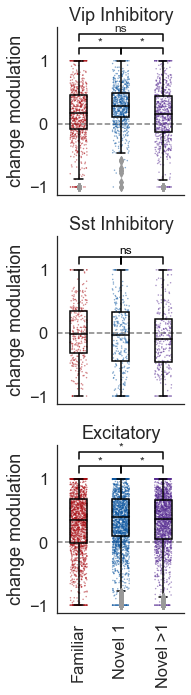

In [39]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4,
                                x='experience_level', y=metric, color='white', ax=ax[i], zorder=10**10)
    # format to have black lines and transparent box face
    plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
    plt.setp(ax[i].lines, color='k', zorder=10**10)
    ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    if cell_type == 'Excitatory':
        ct_data = ct_data.reset_index()
        # get 25% of all data points
        pct=0.25
        n_samples = int(len(ct_data)*pct)
        print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
        idx = np.random.choice(np.arange(len(ct_data)), n_samples)
        # limit to this random subset
        ct_data = ct_data.loc[idx]
    ax[i] = sns.stripplot(data=ct_data, size=1.5, alpha=0.5, jitter=0.2,
                                x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change modulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### split by area

402


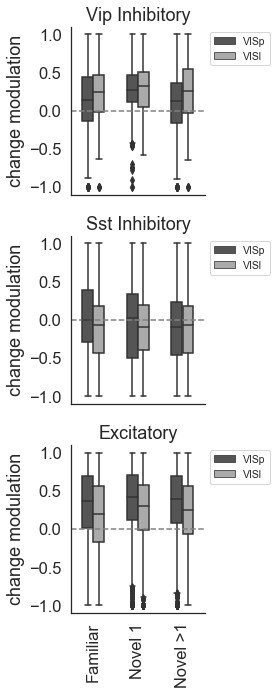

In [40]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.5,
                                x='experience_level', hue='targeted_structure', hue_order=areas, 
                        y=metric, palette='gray', ax=ax[i])
    # format to have black lines and transparent box face
#     plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
#     plt.setp(ax[i].lines, color='k', zorder=10**10)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change modulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

402


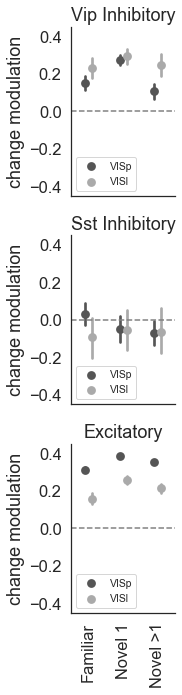

In [41]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, dodge=0.2, join=False,
                                x='experience_level', hue='targeted_structure', hue_order=areas, 
                        y=metric, palette='gray', ax=ax[i])
    # format to have black lines and transparent box face
#     plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
#     plt.setp(ax[i].lines, color='k', zorder=10**10)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    ax[i].legend(fontsize='xx-small', title='', loc='lower left')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change modulation')
    ax[i].set_ylim(-0.45, 0.45)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

## plots for upper vs. lower layers

261


Text(0.52, 1.02, 'V1&LM')

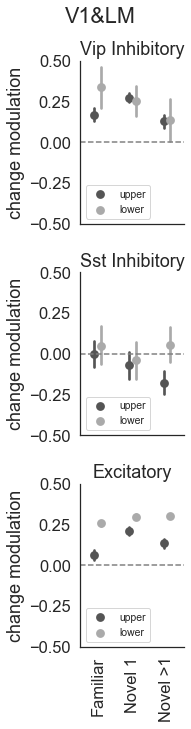

In [42]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5,join=False, dodge=0.2,
                                x='experience_level', hue='layer', hue_order=layers, 
                        y=metric, palette='gray', ax=ax[i])
    # format to have black lines and transparent box face
#     plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
#     plt.setp(ax[i].lines, color='k', zorder=10**10)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    ax[i].legend(fontsize='xx-small', title='', loc='lower left')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change modulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.52, y=1.02)

261


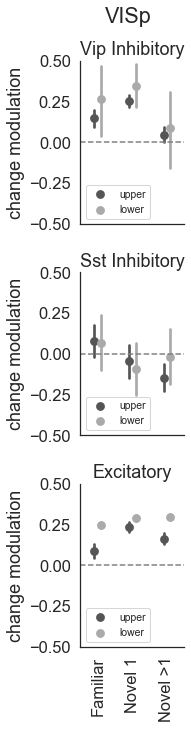

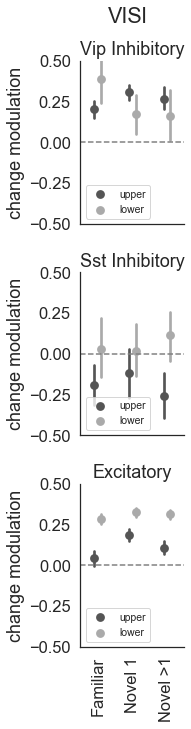

In [43]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']

print(len(data.ophys_experiment_id.unique()))

metric = 'change_modulation_index'

colors = utils.get_experience_level_colors()
for area in areas:
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
    for i,cell_type in enumerate(cell_types):
        ct_data = data[(data.cell_type==cell_type)&(data.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, join=False, dodge=0.2,
                                    x='experience_level', hue='layer', hue_order=layers, 
                            y=metric, palette='gray', ax=ax[i])
        # format to have black lines and transparent box face
    #     plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
    #     plt.setp(ax[i].lines, color='k', zorder=10**10)
    #     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
    #                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    #     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
        ax[i].legend(fontsize='xx-small', title='', loc='lower left')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(-0.5, 0.5)
        ax[i].set_xticklabels(experience_levels, rotation=90)
        ax[i].set_ylabel('change modulation')
    #     ax[i].set_ylim(-1.1, 1.1)
    fig.tight_layout()
    fig.suptitle(area, x=0.65, y=1.02)

### mean response by area and depth

402


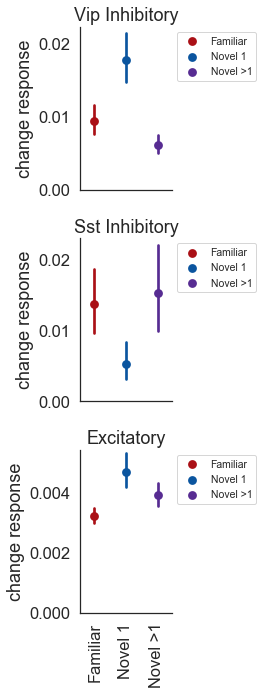

In [44]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=False)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='experience_level', dodge=True, join=False,
                                x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylim(ymin=0)
    ax[i].set_ylabel('change response')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

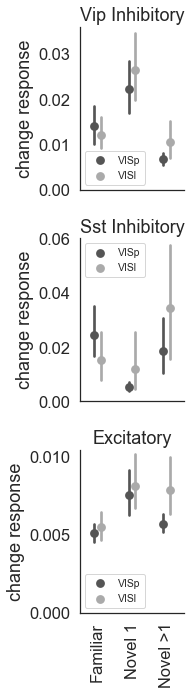

In [45]:
data = metrics_table.copy()
df = data[data.project_code=='VisualBehaviorMultiscope']

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
for i,cell_type in enumerate(cell_types):
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='targeted_structure', hue_order=areas, 
                          dodge=0.2, join=False,
                                x='experience_level', y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change response')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

261


Text(0.65, 1.02, 'V1&LM')

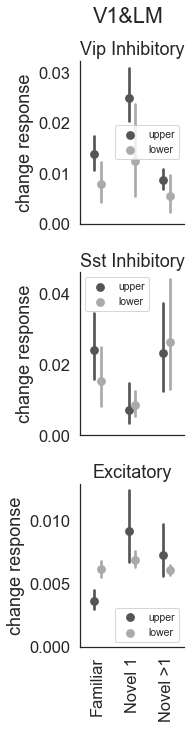

In [46]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
for i,cell_type in enumerate(cell_types):
    ct_data = data[(data.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                          join=False, dodge=0.2, 
                                x='experience_level', y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='',)
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('change response')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.65, y=1.02)

261


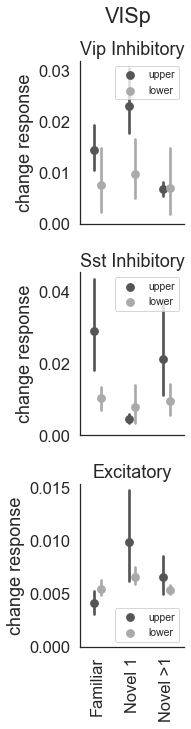

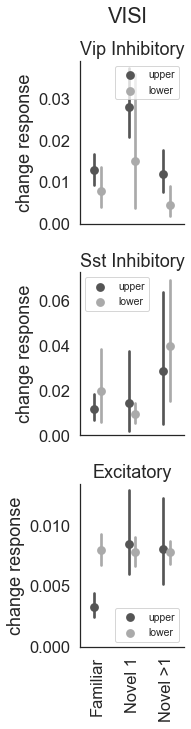

In [47]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
for area in areas: 
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
    for i,cell_type in enumerate(cell_types):
        ct_data = data[(data.cell_type==cell_type)&(data.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                                  join=False, dodge=0.2,
                                    x='experience_level', y=metric, palette='gray', ax=ax[i])
    #     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    #     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
    #                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='',)
    #     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(ymin=0)
        ax[i].set_xticklabels(experience_levels, rotation=90)
        ax[i].set_ylabel('change response')
    #     ax[i].set_ylim(-1.1, 1.1)
    fig.tight_layout()
    fig.suptitle(area, x=0.65, y=1.02)

### mean change response by area and depth 

Text(0.52, 1.02, 'V1&LM')

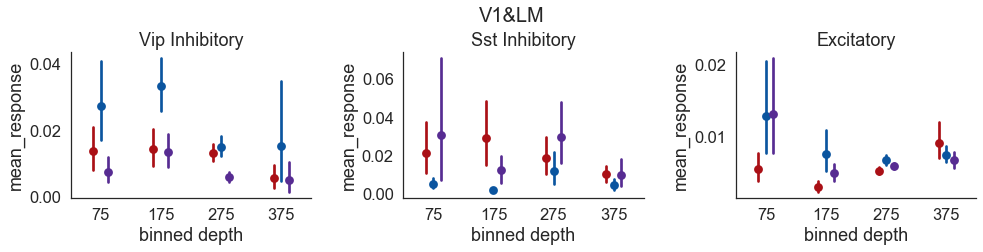

In [48]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

# for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
# df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
df = metrics_table.copy()
df = df[df.project_code=='VisualBehaviorMultiscope']

fig, ax = plt.subplots(1,3, figsize=(14, 3.5))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='binned_depth', y=metric, order=depths, join=False, ax=ax[i],
                      hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#     ax[i].legend(fontsize='xx-small', title='', loc='upper right')
    ax[i].get_legend().remove()
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('binned depth')
#     ax[i].set_ylim(0,0.2)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.52, y=1.02, fontsize=20)

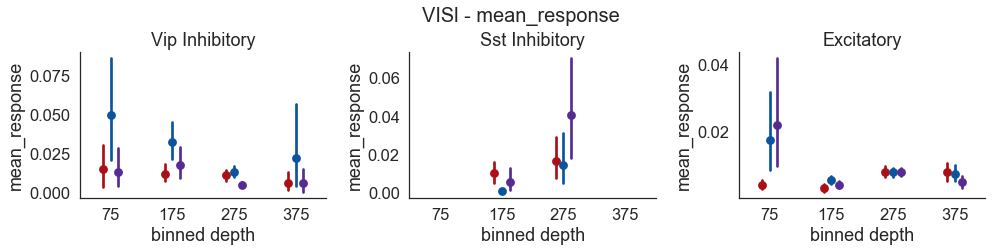

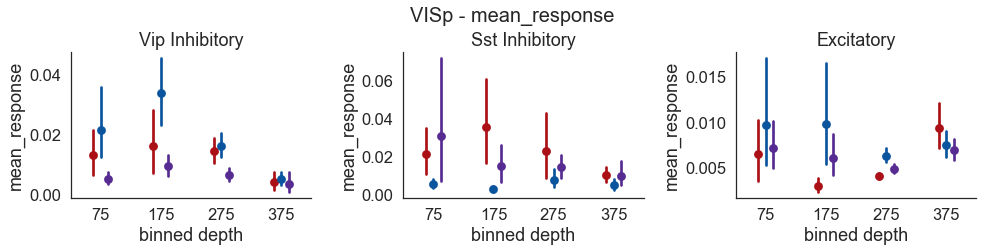

In [49]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
    df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
    df = df[df.project_code=='VisualBehaviorMultiscope']

    fig, ax = plt.subplots(1,3, figsize=(14,3.5))
    for i, cell_type in enumerate(cell_types):
        ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='binned_depth', y=metric, order=depths, join=False, ax=ax[i],
                          hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#         ax[i].legend(fontsize='xx-small', title='', loc='upper right')
        ax[i].get_legend().remove()
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('binned depth')
    #     ax[i].set_ylim(0,0.2)
    fig.tight_layout()
    fig.suptitle(targeted_structure + ' - '+ metric, x=0.52, y=1.02, fontsize=20)

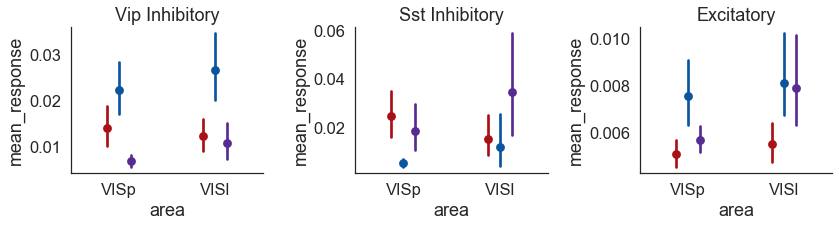

In [50]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

# for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
# df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
df = metrics_table.copy()
df = df[df.project_code=='VisualBehaviorMultiscope']

fig, ax = plt.subplots(1,3, figsize=(12, 3.5))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='targeted_structure', y=metric, order=areas, join=False, ax=ax[i],
                      hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#     ax[i].legend(fontsize='xx-small', title='', loc='upper right')
    ax[i].get_legend().remove()
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('area')
#     ax[i].set_ylim(0,0.2)
fig.tight_layout()
# fig.suptitle(targeted_structure + ' - '+ metric, x=0.52, y=1.02, fontsize=20)

### experience modulation index

In [51]:
print(len(metrics_table.cell_specimen_id.unique()))

# get subset of data of interest
metric = 'mean_response'
metric_data = metrics_table[['cell_specimen_id', 'ophys_experiment_id', metric]]

# merge in metadata for sessions to compare
metric_data = metric_data.merge(experiments_table.reset_index()[['ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id'])

# groupby cell and session number then average across multiple sessions of the same type for each cell
metric_data = metric_data.groupby(['cell_specimen_id', 'experience_level']).mean()[[metric]]
# unstack to get metric for each session number
metric_data = metric_data.unstack()
# get rid of multi index column name
metric_data.columns = metric_data.columns.droplevel(0)

# compute modulation indices
exp_level_1 = 'Familiar'

exp_level_2 = 'Novel 1'
metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])
exp_level_2 = 'Novel >1'
metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])

exp_level_2 = 'Novel 1'
metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])
exp_level_2 = 'Novel >1'
metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])

# add cell type
metric_data = metric_data.merge(cells_table[['cell_specimen_id', 'cell_type']], on='cell_specimen_id')

14495


In [52]:
metric_data = metric_data.drop_duplicates(subset='cell_specimen_id')

In [53]:
df = metric_data[['cell_specimen_id', 'Novel 1 vs. Familiar', 'Novel >1 vs. Familiar', 'cell_type']]
df = df.melt(id_vars=['cell_specimen_id', 'cell_type'], var_name='comparison',
             value_vars=['Novel 1 vs. Familiar', 'Novel >1 vs. Familiar'])
df.head()

,cell_specimen_id,cell_type,comparison,value
0,1086489847,Vip Inhibitory,Novel 1 vs. Familiar,0.450261
1,1086489860,Vip Inhibitory,Novel 1 vs. Familiar,0.425829
2,1086489869,Vip Inhibitory,Novel 1 vs. Familiar,NaN
3,1086489882,Vip Inhibitory,Novel 1 vs. Familiar,NaN
4,1086489891,Vip Inhibitory,Novel 1 vs. Familiar,0.509002


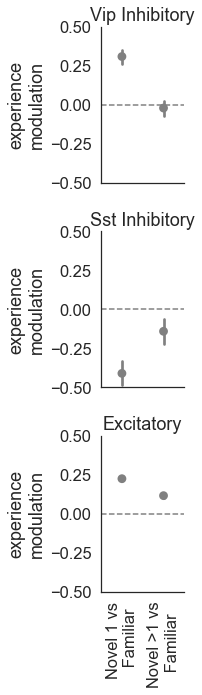

In [54]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
#     ax[i] = sns.violinplot(data=ct_data, width=0.5, cut=0, xorder=xorder,
#                                 x=x, y=metric, color='w', ax=ax[i])
    ax[i] = sns.pointplot(data=ct_data, xorder=xorder, join=False,
                                x=x, y=metric, color='gray', ax=ax[i], zorder=0)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Vip Inhibitory
Sst Inhibitory
Excitatory
6413 is 25.0 % of all Excitatory cells


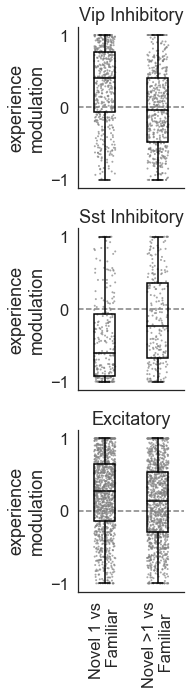

In [55]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4, order=xorder,
                                x=x, y=metric, color='white', ax=ax[i], zorder=10**10)
    # format to have black lines and transparent box face
    plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
    plt.setp(ax[i].lines, color='k', zorder=10**10)
    # for stripplot, only show 10% of excitatory cells
    if cell_type == 'Excitatory':
        ct_data = ct_data.reset_index()
        # get 10% of all data points
        pct=0.25
        n_samples = int(len(ct_data)*pct)
        print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
        idx = np.random.choice(np.arange(len(ct_data)), n_samples)
        # limit to this random subset
        ct_data = ct_data.loc[idx]
    ax[i] = sns.stripplot(data=ct_data, order=xorder, size=2, alpha=0.7, jitter=0.2,
                                x=x, y=metric, color='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### by area and depth

Vip Inhibitory
Sst Inhibitory
Excitatory


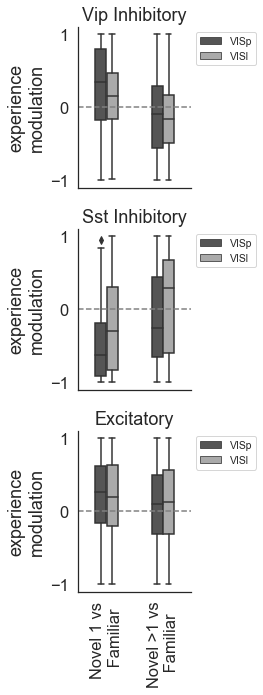

In [56]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

# colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4, order=xorder, hue='targeted_structure', hue_order=areas,
                                x=x, y=metric, palette='gray', ax=ax[i], zorder=10**10)
#     # format to have black lines and transparent box face
#     plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
#     plt.setp(ax[i].lines, color='k', zorder=10**10)
#     # for stripplot, only show 10% of excitatory cells
#     if cell_type == 'Excitatory':
#         ct_data = ct_data.reset_index()
#         # get 10% of all data points
#         pct=0.25
#         n_samples = int(len(ct_data)*pct)
#         print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
#         idx = np.random.choice(np.arange(len(ct_data)), n_samples)
#         # limit to this random subset
#         ct_data = ct_data.loc[idx]
#     ax[i] = sns.stripplot(data=ct_data, order=xorder, size=2, alpha=0.7, jitter=0.2,
#                                 x=x, y=metric, color='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Vip Inhibitory
Sst Inhibitory
Excitatory


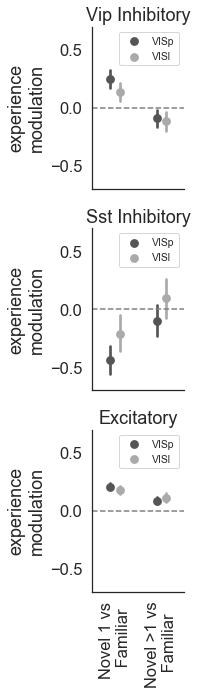

In [57]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

# colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, order=xorder, hue='targeted_structure', hue_order=areas,
                          dodge=0.2, join=False,
                            x=x, y=metric, palette='gray', ax=ax[i], zorder=10**10)

    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
    ax[i].set_ylim(-0.7, 0.7)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Text(0.69, 1.02, 'V1&LM')

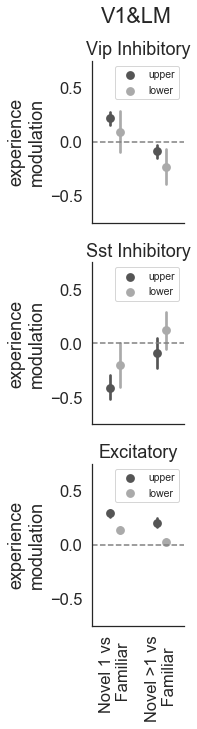

In [58]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.69, y=1.02)

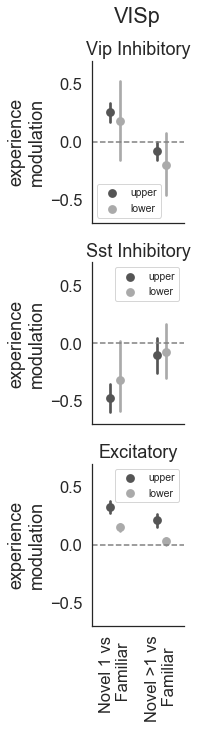

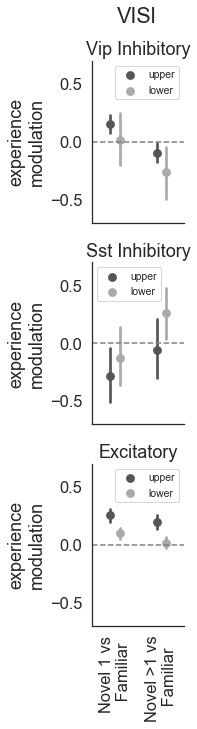

In [59]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'layer', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

for area in areas: 
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
    for i,cell_type in enumerate(cell_types):
        ct_data = df[(df.cell_type==cell_type)&(df.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                              dodge=0.2, join=False,
                                    x=x, y=metric, palette='gray', ax=ax[i])
    #     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    #     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
    #                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(-0.75, 0.75)
        ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
        ax[i].set_ylabel('experience\nmodulation')
        ax[i].set_ylim(-0.7, 0.7)
    fig.tight_layout()
    fig.suptitle(area, x=0.69, y=1.02)

### plot as fraction of Familiar session 

In [60]:
exp_level_2 = 'Novel 1'
metric_col = exp_level_2 +' % of Familiar'
fraction_table1 = metric_data[metric_data[metric_col].isnull()==False] [['cell_specimen_id', metric_col, 'cell_type']]
fraction_table1['experience_level'] = exp_level_2
fraction_table1 = fraction_table1.rename(columns={metric_col:'% of Familiar'})

exp_level_2 = 'Novel >1'
metric_col = exp_level_2 +' % of Familiar'
fraction_table2 = metric_data[metric_data[metric_col].isnull()==False] [['cell_specimen_id', metric_col, 'cell_type']]
fraction_table2['experience_level'] = exp_level_2
fraction_table2 = fraction_table2.rename(columns={metric_col:'% of Familiar'})

fraction_table = pd.concat([fraction_table1, fraction_table2])
fraction_table = fraction_table.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
fraction_table = fraction_table.reset_index(drop=True)
fraction_table = fraction_table.replace([np.inf, -np.inf], np.nan)

In [61]:
fraction_table

,cell_specimen_id,% of Familiar,cell_type,experience_level
0,1086489847,2.638090,Vip Inhibitory,Novel 1
1,1086489860,2.483282,Vip Inhibitory,Novel 1
2,1086489891,3.073332,Vip Inhibitory,Novel 1
3,1086489976,0.358134,Sst Inhibitory,Novel 1
4,1086490002,0.000000,Sst Inhibitory,Novel 1
...,...,...,...,...
10063,1120133628,2.084275,Excitatory,Novel >1
10064,1120133649,1.342584,Excitatory,Novel >1
10065,1120133850,3.571978,Excitatory,Novel >1
10066,1120134009,16.905542,Excitatory,Novel >1


### get rid of outliers

In [62]:
hist_data = fraction_table[fraction_table.cell_type=='Excitatory'][metric].values
print(len(hist_data))
plt.hist(hist_data, bins=50);

KeyError: 'value'

In [ ]:
hist_data = fraction_table[fraction_table.cell_type=='Excitatory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

In [ ]:
hist_data = fraction_table[fraction_table.cell_type=='Vip Inhibitory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

In [ ]:
hist_data = fraction_table[fraction_table.cell_type=='Sst Inhibitory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

In [ ]:
hist_data = fraction_table.copy()
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

In [ ]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, join=False,
                                x=x, y=metric, color='gray', ax=ax[i])
    ax[i].axhline(y=1, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()


In [ ]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='targeted_structure', hue_order=areas, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()


In [ ]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.62, y=1.02)

In [ ]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

for area in areas:
    fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
    for i,cell_type in enumerate(cell_types):
        ct_data = df[(df.cell_type==cell_type)&(df.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                    x=x, y=metric, palette='gray', ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
    #     ax[i].set_ylim(-0.75, 0.75)
        ax[i].set_xticklabels(xorder, rotation=90)
        ax[i].set_ylabel(metric)
    #     ax[i].set_ylim(-1.1, 1.1)
    fig.tight_layout()
    fig.suptitle(area, x=0.62, y=1.02)